In [ ]:
!pip install streamlit
import streamlit as st

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.3 MB/s eta 0:00:00


In [ ]:
!pip install transformers
!pip install torch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from transformers import pipeline

emotion_classifier = pipeline(
    "text-classification",
    model="TuhinG/distilbert-goemotions",
    return_all_scores=True
)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Weighted mapping: base emotions -> child-friendly labels
MAPPING = {
    "joy":           {"Educational":0.05, "Calm":0.10, "Stimulating":0.40, "Hyperactive":0.30, "Distress":0.02, "NotAgeAppropriate":0.0},
    "amusement":     {"Educational":0.05, "Calm":0.05, "Stimulating":0.60, "Hyperactive":0.55, "Distress":0.01, "NotAgeAppropriate":0.0},
    "excitement":    {"Educational":0.02, "Calm":0.02, "Stimulating":0.80, "Hyperactive":0.85, "Distress":0.0,  "NotAgeAppropriate":0.0},
    "surprise":      {"Educational":0.01, "Calm":0.02, "Stimulating":0.70, "Hyperactive":0.60, "Distress":0.05, "NotAgeAppropriate":0.0},
    "curiosity":     {"Educational":0.80, "Calm":0.05, "Stimulating":0.10, "Hyperactive":0.05, "Distress":0.0,  "NotAgeAppropriate":0.0},
    "confusion":     {"Educational":0.05, "Calm":0.02, "Stimulating":0.30, "Hyperactive":0.40, "Distress":0.20, "NotAgeAppropriate":0.0},
    "neutral":       {"Educational":0.30, "Calm":0.80, "Stimulating":0.05, "Hyperactive":0.03, "Distress":0.0,  "NotAgeAppropriate":0.0},
    "sadness":       {"Educational":0.05, "Calm":0.10, "Stimulating":0.05, "Hyperactive":0.02, "Distress":0.60, "NotAgeAppropriate":0.10},
    "fear":          {"Educational":0.0,  "Calm":0.02, "Stimulating":0.05, "Hyperactive":0.02, "Distress":0.95, "NotAgeAppropriate":0.20},
    "anger":         {"Educational":0.0,  "Calm":0.01, "Stimulating":0.05, "Hyperactive":0.10, "Distress":0.70, "NotAgeAppropriate":0.25},
    "disgust":       {"Educational":0.0,  "Calm":0.01, "Stimulating":0.05, "Hyperactive":0.05, "Distress":0.50, "NotAgeAppropriate":0.40},
    "admiration":    {"Educational":0.15, "Calm":0.30, "Stimulating":0.10, "Hyperactive":0.05, "Distress":0.0,  "NotAgeAppropriate":0.0},
    "gratitude":     {"Educational":0.10, "Calm":0.40, "Stimulating":0.05, "Hyperactive":0.02, "Distress":0.0,  "NotAgeAppropriate":0.0},
    "love":          {"Educational":0.05, "Calm":0.40, "Stimulating":0.05, "Hyperactive":0.02, "Distress":0.0,  "NotAgeAppropriate":0.0},
    "relief":        {"Educational":0.10, "Calm":0.60, "Stimulating":0.02, "Hyperactive":0.01, "Distress":0.0,  "NotAgeAppropriate":0.0},
    "optimism":      {"Educational":0.10, "Calm":0.10, "Stimulating":0.20, "Hyperactive":0.10, "Distress":0.0,  "NotAgeAppropriate":0.0},
}

TARGET_LABELS = ["Educational","Calm","Stimulating","Hyperactive","Distress","NotAgeAppropriate"]

NA_KEYWORDS = [
    "sex", "kill", "murder", "rape", "fuck", "shit", "bitch", "bomb", "suicide",
    "drugs", "cocaine", "weapon", "gun", "stab", "porn", "nude", "breast"
]

# Mapping from model's LABEL_X to human-readable emotion names for TuhinG/distilbert-goemotions
LABELS_ORDER = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

LABEL_TO_EMOTION_NAME = {f"LABEL_{i}": label_name for i, label_name in enumerate(LABELS_ORDER)}


In [ ]:
def map_emotions_to_custom(base_emotion_scores, text_chunk=""):
    accum = {t: 0.0 for t in TARGET_LABELS}

    for item in base_emotion_scores:
        model_label = item['label']
        score = float(item['score'])
        # Map LABEL_X to emotion name
        emotion_name = LABEL_TO_EMOTION_NAME.get(model_label, None)
        if emotion_name and emotion_name in MAPPING:
            for t, w in MAPPING[emotion_name].items():
                accum[t] += w * score

    lower = text_chunk.lower()
    keyword_hits = sum(1 for k in NA_KEYWORDS if k in lower)
    if keyword_hits > 0:
        accum['NotAgeAppropriate'] += min(1.0, 0.25 * keyword_hits)

    total = sum(accum.values()) + 1e-9
    normalized = {k: v/total for k,v in accum.items()}
    return normalized


In [ ]:
text_chunks = [
    "I love learning new things with my friends!",
    "Oh no! That was scary!",
    "Let's play and jump around!"
]

all_scores = []

for chunk in text_chunks:
    # Access the inner list of dictionaries from the model output
    base_emotions = emotion_classifier(chunk)[0]  # model output
    child_scores = map_emotions_to_custom(base_emotions, text_chunk=chunk)
    all_scores.append(child_scores)

# Aggregate final scores
final_scores = {label: sum(d[label] for d in all_scores)/len(all_scores) for label in TARGET_LABELS}

print("Final Child-Friendly Emotion Scores:")
for k,v in final_scores.items():
    print(f"{k}: {v:.2f}")


Final Child-Friendly Emotion Scores:
Educational: 0.12
Calm: 0.20
Stimulating: 0.23
Hyperactive: 0.21
Distress: 0.19
NotAgeAppropriate: 0.06


In [ ]:
text_chunks = [
    "Today we are going to count 1, 2, 3, and learn colors with our toys!",
    "Watch as the puppy runs and jumps in the garden!",
    "Be careful not to touch the stove, it’s hot!",
    "Hooray! We made a rainbow with the paints!",
    "Oh no! The tower of blocks fell down!",
    "Let's sing the alphabet song together!"
]

all_scores = []

for chunk in text_chunks:
    # Access the inner list of dictionaries from the model output
    base_emotions = emotion_classifier(chunk)[0]  # model output
    child_scores = map_emotions_to_custom(base_emotions, text_chunk=chunk)
    all_scores.append(child_scores)

# Aggregate final scores
final_scores = {label: sum(d[label] for d in all_scores)/len(all_scores) for label in TARGET_LABELS}

print("Final Child-Friendly Emotion Scores:")
for k,v in final_scores.items():
    print(f"{k}: {v:.2f}")


Final Child-Friendly Emotion Scores:
Educational: 0.12
Calm: 0.20
Stimulating: 0.23
Hyperactive: 0.20
Distress: 0.19
NotAgeAppropriate: 0.06


In [ ]:
def map_emotions_to_custom_raw(base_emotion_scores):
    accum = {t: 0.0 for t in TARGET_LABELS}
    for item in base_emotion_scores:
        model_label = item['label']
        score = float(item['score'])
        # Map LABEL_X to emotion name
        emotion_name = LABEL_TO_EMOTION_NAME.get(model_label, None)
        if emotion_name and emotion_name in MAPPING:
            for t, w in MAPPING[emotion_name].items():
                accum[t] += w * score
    return accum


In [ ]:
for chunk in text_chunks:
    base_emotions = emotion_classifier(chunk)
    # Access the inner list of dictionaries and pass it to the mapping function
    print(map_emotions_to_custom_raw(base_emotions[0]))


{'Educational': 0.9111513426899911, 'Calm': 1.5229847654700281, 'Stimulating': 1.7769548985362054, 'Hyperactive': 1.5836349138617518, 'Distress': 1.4858142393827436, 'NotAgeAppropriate': 0.47157000452280046}
{'Educational': 0.9144759571552276, 'Calm': 1.526268795132637, 'Stimulating': 1.7693635892868043, 'Hyperactive': 1.5786120146512985, 'Distress': 1.5026685485243798, 'NotAgeAppropriate': 0.47530481815338144}
{'Educational': 0.910653440952301, 'Calm': 1.5200268289446832, 'Stimulating': 1.7922250208258628, 'Hyperactive': 1.601428416073322, 'Distress': 1.4919985151290895, 'NotAgeAppropriate': 0.47126521021127704}
{'Educational': 0.9121679976582527, 'Calm': 1.5201115736365318, 'Stimulating': 1.786220300793648, 'Hyperactive': 1.5947202476859095, 'Distress': 1.5024292987585068, 'NotAgeAppropriate': 0.4762314230203628}
{'Educational': 0.9135033857822419, 'Calm': 1.512588646709919, 'Stimulating': 1.7973329919576646, 'Hyperactive': 1.6066332051157952, 'Distress': 1.502390630543232, 'NotAgeAp

In [ ]:
text_chunks = [
    "Today we are going to count 1, 2, 3, and learn colors with our toys!",
    "Watch as the puppy runs and jumps in the garden!",
    "Be careful not to touch the stove, it’s hot!",
    "Hooray! We made a rainbow with the paints!",
    "Oh no! The tower of blocks fell down!",
    "Let's sing the alphabet song together!"
]

all_scores = []

for chunk in text_chunks:
    base_emotions = emotion_classifier(chunk)[0]  # model output
    child_scores = map_emotions_to_custom(base_emotions, text_chunk=chunk)
    all_scores.append(child_scores)

# Aggregate final scores
final_scores = {label: sum(d[label] for d in all_scores)/len(all_scores) for label in TARGET_LABELS}

print("Final Child-Friendly Emotion Scores:")
for k,v in final_scores.items():
    print(f"{k}: {v:.2f}")


Final Child-Friendly Emotion Scores:
Educational: 0.12
Calm: 0.20
Stimulating: 0.23
Hyperactive: 0.20
Distress: 0.19
NotAgeAppropriate: 0.06


In [ ]:
!pip install yt-dlp
import subprocess, os, re, glob

def get_youtube_transcript(url):
    # Extract video ID
    video_id_match = re.search(r"v=([a-zA-Z0-9_-]+)", url)
    if not video_id_match:
        raise ValueError("Invalid YouTube URL")
    video_id = video_id_match.group(1)

    # Remove old files to avoid confusion
    for f in glob.glob(f"{video_id}*.vtt"):
        os.remove(f)

    # Download auto subtitles with yt-dlp
    subprocess.run([
        "yt-dlp",
        "--write-auto-sub",
        "--sub-lang", "en",
        "--skip-download",
        "-o", f"{video_id}.%(ext)s",   # let yt-dlp handle suffix
        url
    ], check=True)

    # Find the actual subtitle file (yt-dlp sometimes names it weirdly)
    vtt_files = glob.glob(f"{video_id}*.vtt")

    if not vtt_files:
        raise FileNotFoundError("Subtitle file not found. This video may have no captions.")

    vtt_file = vtt_files[0]  # use the first matching file

    print("Found subtitle file:", vtt_file)

    # Read and clean the VTT file
    with open(vtt_file, "r", encoding="utf-8") as f:
        text = f.read()

    # Remove timestamps and formatting
    text = re.sub(r'\d+:\d+\.\d+ --> \d+:\d+\.\d+', ' ', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# ---- Test ----
url = "https://www.youtube.com/watch?v=7qlfKBRn3fU"  # example
transcript = get_youtube_transcript(url)
print(transcript[:300])


Found subtitle file: 7qlfKBRn3fU.en.vtt
WEBVTT Kind: captions Language: en 00:00:00.000 --> 00:00:00.390 align:start position:0% [Music] 00:00:00.390 --> 00:00:00.400 align:start position:0% [Music] 00:00:00.400 --> 00:00:04.630 align:start position:0% [Music] How to become when Stacy? What? Don't 00:00:04.630 --> 00:00:04.640 align:start


In [ ]:
import re

def clean_transcript(raw_text):
    # Remove [Music], [Applause], [Laughter], etc.
    text = re.sub(r'\[.*?\]', ' ', raw_text)

    # Remove timestamps like "00:00:01.230 --> 00:00:03.450"
    text = re.sub(r'\d+:\d+\.\d+\s*-->\s*\d+:\d+\.\d+', ' ', text)

    # Remove WEBVTT metadata header
    text = re.sub(r'WEBVTT.*?Language: en', ' ', text, flags=re.DOTALL)

    # Remove leftover HTML tags (rare but possible)
    text = re.sub(r'<.*?>', '', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

cleaned_text = clean_transcript(transcript)

print("CLEANED TEXT PREVIEW:")
print(cleaned_text[:600])  # first 600 characters


CLEANED TEXT PREVIEW:
00:00:00.000 --> 00:00:00.390 align:start position:0% 00:00:00.390 --> 00:00:00.400 align:start position:0% 00:00:00.400 --> 00:00:04.630 align:start position:0% How to become when Stacy? What? Don't 00:00:04.630 --> 00:00:04.640 align:start position:0% How to become when Stacy? What? Don't 00:00:04.640 --> 00:00:06.950 align:start position:0% How to become when Stacy? What? Don't even dream about it. You're not even 00:00:06.950 --> 00:00:06.960 align:start position:0% even dream about it. You're not even 00:00:06.960 --> 00:00:10.709 align:start position:0% even dream about it. You're not ev


In [ ]:
import re

def clean_transcript_strong(raw_text):
    text = raw_text

    # Remove lines that contain position/alignment metadata
    text = re.sub(r'align:start.*?%', ' ', text)

    # Remove timestamps (00:00:00.000 --> 00:00:00.000)
    text = re.sub(r'\d{2}:\d{2}:\d{2}\.\d{3}\s*-->\s*\d{2}:\d{2}:\d{2}\.\d{3}', ' ', text)

    # Remove WEBVTT header
    text = re.sub(r'WEBVTT.*?(?=\d{2}:\d{2}:\d{2})', ' ', text, flags=re.DOTALL)

    # Remove anything inside brackets like [Music]
    text = re.sub(r'\[.*?\]', ' ', text)

    # Remove HTML-like tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove numbers that appear alone (sometimes timestamps leave stray values)
    text = re.sub(r'\b\d+\b', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

cleaned_text = clean_transcript_strong(transcript)

print("CLEANED TEXT PREVIEW:")
print(cleaned_text[:600])


CLEANED TEXT PREVIEW:
WEBVTT Kind: captions Language: en How to become when Stacy? What? Don't How to become when Stacy? What? Don't How to become when Stacy? What? Don't even dream about it. You're not even even dream about it. You're not even even dream about it. You're not even close to her. I'll prove it to you all. close to her. I'll prove it to you all. close to her. I'll prove it to you all. And then Spider Boy will definitely fall And then Spider Boy will definitely fall And then Spider Boy will definitely fall in love with me. Let's see. Oh, when in love with me. Let's see. Oh, when in love with me. Let's 


In [ ]:
# split cleaned text into chunks of ~300 characters
chunk_size = 300
chunks = [cleaned_text[i:i+chunk_size] for i in range(0, len(cleaned_text), chunk_size)]

print("Number of chunks:", len(chunks))
print("\nSample chunk:\n", chunks[0])


Number of chunks: 359

Sample chunk:
 WEBVTT Kind: captions Language: en How to become when Stacy? What? Don't How to become when Stacy? What? Don't How to become when Stacy? What? Don't even dream about it. You're not even even dream about it. You're not even even dream about it. You're not even close to her. I'll prove it to you all. 


In [ ]:
!pip install transformers datasets --quiet


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

model_name = "SamLowe/roberta-base-go_emotions"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# get emotion labels
labels = [
    'admiration','amusement','anger','annoyance','approval','caring',
    'confusion','curiosity','desire','disappointment','disapproval','disgust',
    'embarrassment','excitement','fear','gratitude','grief','joy','love',
    'nervousness','optimism','pride','realization','relief','remorse','sadness',
    'surprise','neutral'
]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def map_raw_emotion_to_custom(raw_emotion, score):
    if raw_emotion not in MAPPING:
        return None  # ignore weird labels

    weights = MAPPING[raw_emotion]

    # Multiply raw emotion probability with mapping weight
    mapped = {label: score * weight for label, weight in weights.items()}
    return mapped


In [ ]:
from collections import defaultdict

def aggregate_custom_scores(all_model_outputs):
    final_scores = defaultdict(float)

    for raw_label, raw_prob in all_model_outputs:
        mapped_scores = map_raw_emotion_to_custom(raw_label, raw_prob)
        if mapped_scores:
            for cat, val in mapped_scores.items():
                final_scores[cat] += val

    # Normalize to 0–1
    total = sum(final_scores.values())
    if total > 0:
        for k in final_scores:
            final_scores[k] /= total

    return dict(final_scores)


In [ ]:
!pip install transformers torch --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model
tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")
model = AutoModelForSequenceClassification.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

EMOTIONS = model.config.id2label


tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def get_emotion_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1).numpy()[0]

    return {EMOTIONS[i]: float(probs[i]) for i in range(len(probs))}


In [ ]:
MAPPING = {
    "joy": {"Educational":0.05,"Calm":0.10,"Stimulating":0.40,"Hyperactive":0.30,"Distress":0.02,"NotAgeAppropriate":0.0},
    "amusement": {"Educational":0.05,"Calm":0.05,"Stimulating":0.60,"Hyperactive":0.55,"Distress":0.01,"NotAgeAppropriate":0.0},
    "excitement": {"Educational":0.02,"Calm":0.02,"Stimulating":0.80,"Hyperactive":0.85,"Distress":0.0,"NotAgeAppropriate":0.0},
    "surprise": {"Educational":0.01,"Calm":0.02,"Stimulating":0.70,"Hyperactive":0.60,"Distress":0.05,"NotAgeAppropriate":0.0},
    "curiosity": {"Educational":0.80,"Calm":0.05,"Stimulating":0.10,"Hyperactive":0.05,"Distress":0.0,"NotAgeAppropriate":0.0},
    "confusion": {"Educational":0.05,"Calm":0.02,"Stimulating":0.30,"Hyperactive":0.40,"Distress":0.20,"NotAgeAppropriate":0.0},
    "neutral": {"Educational":0.30,"Calm":0.80,"Stimulating":0.05,"Hyperactive":0.03,"Distress":0.0,"NotAgeAppropriate":0.0},
    "sadness": {"Educational":0.05,"Calm":0.10,"Stimulating":0.05,"Hyperactive":0.02,"Distress":0.60,"NotAgeAppropriate":0.10},
    "fear": {"Educational":0.0,"Calm":0.02,"Stimulating":0.05,"Hyperactive":0.02,"Distress":0.95,"NotAgeAppropriate":0.20},
    "anger": {"Educational":0.0,"Calm":0.01,"Stimulating":0.05,"Hyperactive":0.10,"Distress":0.70,"NotAgeAppropriate":0.25},
    "disgust": {"Educational":0.0,"Calm":0.01,"Stimulating":0.05,"Hyperactive":0.05,"Distress":0.50,"NotAgeAppropriate":0.40},
    "admiration": {"Educational":0.15,"Calm":0.30,"Stimulating":0.10,"Hyperactive":0.05,"Distress":0.0,"NotAgeAppropriate":0.0},
    "gratitude": {"Educational":0.10,"Calm":0.40,"Stimulating":0.05,"Hyperactive":0.02,"Distress":0.0,"NotAgeAppropriate":0.0},
    "love": {"Educational":0.05,"Calm":0.40,"Stimulating":0.05,"Hyperactive":0.02,"Distress":0.0,"NotAgeAppropriate":0.0},
    "relief": {"Educational":0.10,"Calm":0.60,"Stimulating":0.02,"Hyperactive":0.01,"Distress":0.0,"NotAgeAppropriate":0.0},
    "optimism": {"Educational":0.10,"Calm":0.10,"Stimulating":0.20,"Hyperactive":0.10,"Distress":0.0,"NotAgeAppropriate":0.0}
}

TARGET_LABELS = ["Educational","Calm","Stimulating","Hyperactive","Distress","NotAgeAppropriate"]


In [ ]:
def map_emotions_to_categories(emotion_scores):
    category_totals = {key: 0.0 for key in TARGET_LABELS}

    for emotion, prob in emotion_scores.items():
        if emotion in MAPPING:
            weights = MAPPING[emotion]
            for cat in TARGET_LABELS:
                category_totals[cat] += prob * weights[cat]

    total = sum(category_totals.values())
    if total > 0:
        category_totals = {k: (v/total)*100 for k,v in category_totals.items()}

    return category_totals


In [ ]:
cleaned_text


"WEBVTT Kind: captions Language: en How to become when Stacy? What? Don't How to become when Stacy? What? Don't How to become when Stacy? What? Don't even dream about it. You're not even even dream about it. You're not even even dream about it. You're not even close to her. I'll prove it to you all. close to her. I'll prove it to you all. close to her. I'll prove it to you all. And then Spider Boy will definitely fall And then Spider Boy will definitely fall And then Spider Boy will definitely fall in love with me. Let's see. Oh, when in love with me. Let's see. Oh, when in love with me. Let's see. Oh, when Stacy has to have clear skin. I want Stacy has to have clear skin. I want Stacy has to have clear skin. I want that, too. Yeah. that, too. Yeah. that, too. Yeah. Wow. There's a drawing of Hello Kitty. Wow. There's a drawing of Hello Kitty. Wow. There's a drawing of Hello Kitty. What does this mean? me. Oh, who helped me put gum on me? It me. Oh, who helped me put gum on me? It me. O

In [ ]:
def chunk_text(text, max_words=40):
    words = text.split()
    for i in range(0, len(words), max_words):
        yield " ".join(words[i:i+max_words])


In [ ]:
final_scores = {key:0.0 for key in TARGET_LABELS}

for chunk in chunk_text(cleaned_text):
    raw_emotions = get_emotion_scores(chunk)
    mapped = map_emotions_to_categories(raw_emotions)
    for k in TARGET_LABELS:
        final_scores[k] += mapped[k]

# Normalize again
total = sum(final_scores.values())
final_scores = {k:(v/total)*100 for k,v in final_scores.items()}

final_scores


{'Educational': 4.045738651717438,
 'Calm': 9.318949700719218,
 'Stimulating': 29.06729543240759,
 'Hyperactive': 22.671327944963934,
 'Distress': 27.82908857080897,
 'NotAgeAppropriate': 7.067599699382847}

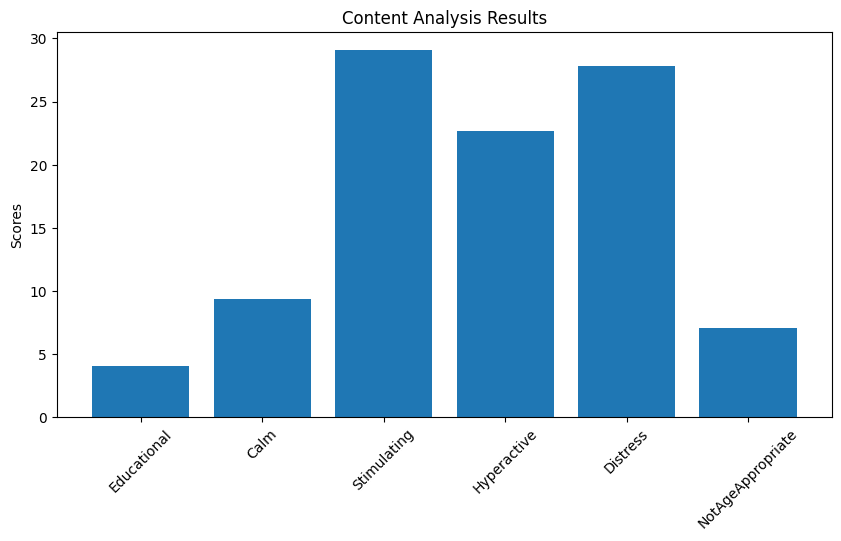

In [ ]:
import matplotlib.pyplot as plt

data = {
    'Educational': 4.045738651717438,
    'Calm': 9.318949700719218,
    'Stimulating': 29.06729543240759,
    'Hyperactive': 22.671327944963934,
    'Distress': 27.82908857080897,
    'NotAgeAppropriate': 7.067599699382847
}

labels = list(data.keys())
values = list(data.values())

plt.figure(figsize=(10,5))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.ylabel("Scores")
plt.title("Content Analysis Results")
plt.show()


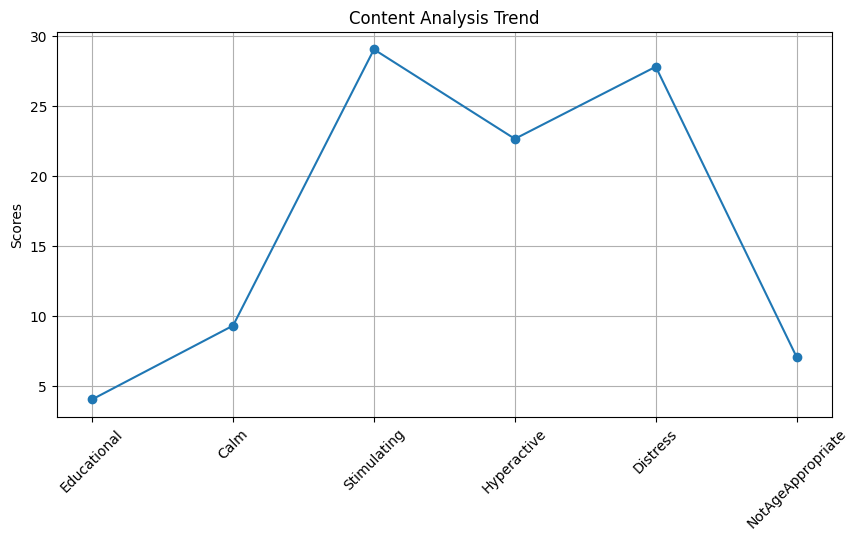

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(labels, values, marker='o')
plt.xticks(rotation=45)
plt.ylabel("Scores")
plt.title("Content Analysis Trend")
plt.grid(True)
plt.show()


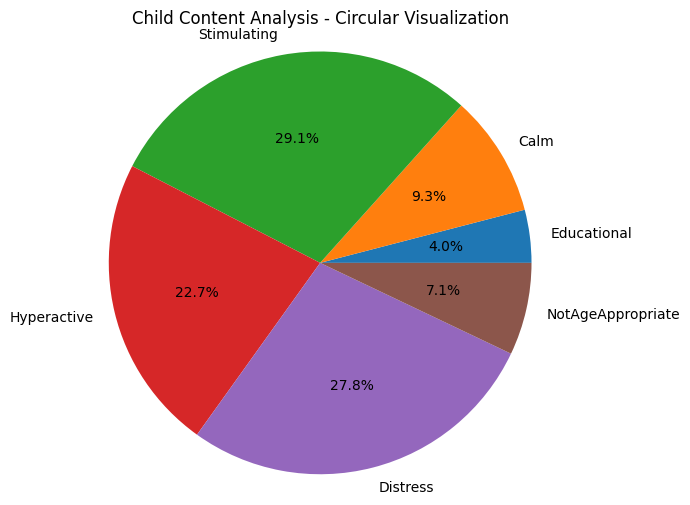

<Figure size 640x480 with 0 Axes>

In [ ]:
labels = list(data.keys())
sizes = list(data.values())

# Create figure
plt.figure(figsize=(6,6))

# Pie chart (circle-shaped)
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Makes the pie a perfect circle
plt.title("Child Content Analysis - Circular Visualization")

# Display on screen
plt.show()

# Save as image
plt.savefig("child_content_circle.png", dpi=300, bbox_inches='tight')

In [ ]:
%%writefile requirements.txt
streamlit


Writing requirements.txt


In [ ]:
%%writefile requirements.txt
streamlit
pandas
numpy
scikit-learn


Overwriting requirements.txt


In [ ]:
/content/app.py